IF USING PYTHON 3, DO NOT USE QUOTES.

How would you like the data to be analyzed?
"1" Parse data automatically using only the Full Name and Values.
"2" Parse data manually by specifying columns.
We found the following columns:
['Cell' 'Promoter' 'Unnamed: 2' '8h' '24h' '48h'
 'Expression (Fold over WT)' '24h.1' '48h.1' 'Fold Change'
 'Fold Change (log 2)']

Which column would you like to occupy the y-axis?: Expression (Fold over WT)


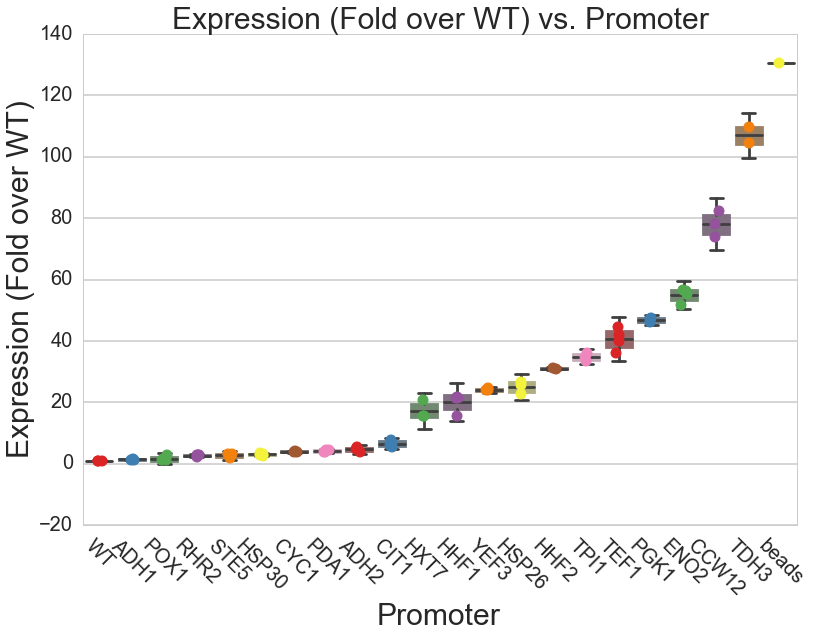

In [5]:
##### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas as pd
%matplotlib inline  

# Parses the excel file manually 
def parseExcelManual(filename):
    df = pd.read_excel(filename)
    print("We found the following columns:")
    print(df.columns.values)
    print("")
    xcol = "Promoter" #input("Which column would you like to occupy the x-axis?: ")
    
    while xcol not in df.columns.values:
        print("Invalid column name")
        xcol = input("Please enter a valid column name: ")

    ycol = input("Which column would you like to occupy the y-axis?: ")
    while ycol not in df.columns.values:
        print("Invalid column name")
        ycol = input("Please enter a valid column name: ")

    title = ycol + " vs. " + xcol
    
    # making a new series, where xcol is the label, and then makes correspondence
    # between the label and the value
    DataOrg = pd.DataFrame(data={xcol: df[xcol], ycol: df[ycol]})
    
    # dropna removes anything thats without a value (NaN)
    DataOrg = DataOrg.dropna(axis = 0)
    
    # flips/trasnposes to make it easier to work with 
    DataOrg = DataOrg.pivot_table(ycol, xcol, DataOrg.index)
    DataOrg = DataOrg.T

    box = "y" #input("Do you want a boxplot? (y/n): ")
    normalize = "n" #input("Do you want to normalize the y-axis? (y/n): ")
    if normalize == 'y':
        # amax is the max value of the values, fills NaN with zeroes
        DataOrg = DataOrg / np.amax(reorg.fillna(0).values)
        title = title + " Normalized"
    
    # Gets the mean of each column, orders the means by ascending value and reorders the columns based on the means.
    DataOrg = DataOrg.reindex_axis(DataOrg.mean().order().index, axis=1)
        
    if box == "y":
        makeBoxplot(DataOrg)
    sns.stripplot(data=DataOrg, size = 10, jitter = True, palette = sns.color_palette("Set1", n_colors=8, desat=.9))
    
    #here make styles
    sns.set_context("poster")
    sns.set_style("whitegrid")
    plt.ylabel(ycol, fontsize=30)
    plt.xlabel(xcol, fontsize=30)
    plt.title(title, fontsize=30)
    #plt.gca().set_ylim(bottom = 0)
    plt.xticks(size=20, rotation=315) 
    plt.yticks(size=20) 

    plt.show()

# Parses the excel condition data file and organizes it into a dataframe.
def parseExcelCondition(filename):
    df = pd.read_excel(filename, index = False)
    # Placeholder columns
    df['Date'] = ""
    df['Gene'] = "a"
    df['Sample'] = "b"
    df['Condition'] = "c"
    df2 = pd.DataFrame()

    # Iterates through, extracting data from the full name. 
    for i in df.iterrows():
        _, series = i;

        fullName = series[0]
        splitName = fullName.split("_")
        date = splitName[0]
        gene = splitName[1]
        sample = splitName[2]
        condition = splitName[3]

        series.replace(series.get('Date'), date, inplace = True)
        series.replace(series.get('Gene'), gene, inplace = True)
        series.replace(series.get('Sample'), sample, inplace = True)
        series.replace(series.get('Condition'), condition, inplace = True)
        df2 = df2.append(series)

    # Reorganizes the data into something more readable, without the full name.
    df2 = df2[['Gene', 'Date', 'Sample', 'Condition', 'Values']]

    return df2

def conditionPlot(data):

    data = data.pivot_table('Values', ['Sample'], ['Gene', 'Condition'])
    answer = input("Do you want a boxplot to go with your data? (y/n): ")
    normalize = input("Would you like to normalize the y-axis? (y/n): ")
    if normalize == 'y':
        data = data / np.amax(data.fillna(0).values)
        
    if answer == "y":
        makeBoxplot(data)
        # Iterate through the columns, generating data to form the boxplot.

    #INSERT HERE
    #sns.stripplot(data=data, size = 7, jitter = True, palette = sns.color_palette("Set1", n_colors=8, desat=.9))
    #ylabel = input("What should the y-axis label be?: ")
    #set_context("talk", font_scale=5)
    #plt.ylabel(ylabel, fontsize=30)
    #plt.xlabel('Gene/Condition', rotation=270, fontsize=30)
    #plt.show()




def makeBoxplot(tempTable):
    # making separate data frame with mean, std, etc, over std(0), which is
    # the category name
    stdevSeries = tempTable.std(0)
    meanSeries = tempTable.mean(0)
    boxTable = tempTable.copy(deep=True)
    boxTable = boxTable.T.drop(boxTable.T, axis = 1)
    boxTable = boxTable.T

    # Iterate through the rows to find the psuedo data for boxplot.
    for index, value in stdevSeries.iteritems():
        mean = meanSeries[index]
        stdev = stdevSeries[index]
        # make a separate data frame containing mean, std dev etc
        tempSer = pd.Series(data=[mean-2*stdev,mean-stdev,mean-stdev/2,mean,mean+stdev/2,mean+stdev,mean+2*stdev],
                            index = [1, 2, 3, 4, 5, 6, 7])
        boxTable[index] = tempSer
    
    #set style
    sns.set_context("poster")
    sns.set_style("whitegrid")
    sns.boxplot(data=boxTable, palette = sns.color_palette("Set1", n_colors=8, desat=.3))

    
# Initial user interface.

def askUser():
    print("IF USING PYTHON 3, DO NOT USE QUOTES.")
    filename = "20151113_PromoterDaniel.xlsx" #input("What is the filename of the data to be analyzed?: ")
    print("")
    print("How would you like the data to be analyzed?")
    print("\"1\" Parse data automatically using only the Full Name and Values.")
    print("\"2\" Parse data manually by specifying columns.")
    parser = "2" #input("Your answer: ")

    if parser == "1":
        if isTime(filename):
            data = parseExcelTime(filename)
            answer = input("Do you want a linear regression for your data? (y/n): ")
            if answer == "n":
                timePlotScatter(data)
            else:
                timePlotLine(data)
        else:
            data = parseExcelCondition(filename)
            conditionPlot(data)
    else:
        parseExcelManual(filename)

askUser()

# Testing Files:
# conditionData.xlsx
# timeData.xlsx
# leodata2.xlsx